In [22]:
from PIL import Image
from torch.utils.data.dataset import Dataset
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler

In [23]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path):
        
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]
                            )
        self.resize = transforms.Resize(224)
        self.crop = transforms.CenterCrop(224)
        self.data_info = pd.read_csv(csv_path, header=0)
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])
        self.label_arr = np.asarray(self.data_info.iloc[:, 3])
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]+'.jpg'
        img = Image.open('./images/'+single_image_name)
        img = self.resize(img)
        img = self.crop(img)
        img_as_tensor = self.to_tensor(img)
        img_as_tensor = self.normalize(img_as_tensor)
        single_image_label = self.label_arr[index]
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

if __name__ == "__main__":
    # Call dataset
    landmarks_train =  \
        CustomDatasetFromImages('./train.csv')

In [3]:
batch_size = 30
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(landmarks_train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(landmarks_train, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(landmarks_train, batch_size=batch_size, sampler=valid_sampler)

In [6]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([64, 3, 224, 224]) torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


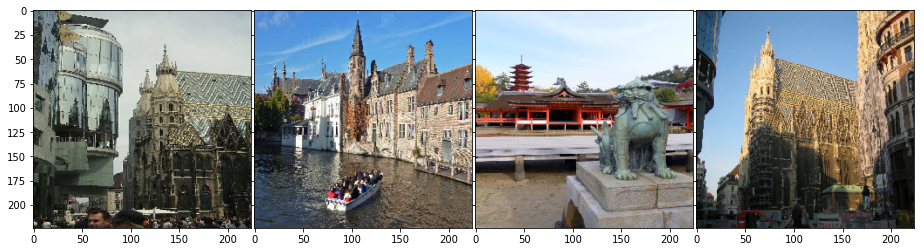

In [20]:
img, label = next(iter(train_loader))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(4):
    ax = grid[i]
    imshow(ax, img[i])

In [8]:
use_gpu = torch.cuda.is_available()
volatile=True
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_loader))
resnet = resnet.cuda()
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
outputs = resnet(inputs)
outputs.size()

torch.Size([64, 1000])

In [9]:
def train_model(data, model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(data['train'].dataset), 
                     'valid': len(dataldataoders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in data[phase]:
                if use_gpu:
                    inputs, labels = inputs.cuda(), Variable(labels.cuda())
                else:
                    inputs, labels = inputs, Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc =  (running_corrects).data.cpu().numpy() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc =  (running_corrects).data.cpu().numpy() / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

#         print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
#               'valid loss: {:.4f} acc: {:.4f}'.format(
#                 epoch, num_epochs - 1,
#                 train_epoch_loss, train_epoch_acc, 
#                 valid_epoch_loss, valid_epoch_acc))
            
#     print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [10]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 10)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

dloaders = {'train':train_loader, 'valid':valid_loader}

In [11]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=5)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

C:\Users\hardi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [0/4] train loss: 0.0119 acc: 0.5989 valid loss: 0.0018 acc: 0.1686
Epoch [1/4] train loss: 0.0064 acc: 0.6891 valid loss: 0.0014 acc: 0.1729
Epoch [2/4] train loss: 0.0054 acc: 0.7028 valid loss: 0.0013 acc: 0.1752
Epoch [3/4] train loss: 0.0049 acc: 0.7106 valid loss: 0.0012 acc: 0.1766
Epoch [4/4] train loss: 0.0046 acc: 0.7151 valid loss: 0.0011 acc: 0.1776
Best val Acc: 0.177623
Training time:  75.791161 minutes


In [14]:
class CustomDatasetFromImagesTest(Dataset):
    def __init__(self, csv_path):
        
        # Transforms
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]
                            )
        self.crop = transforms.CenterCrop(224)
        self.data_info = pd.read_csv(csv_path, header=0)
        self.image_arr = np.asarray(self.data_info.iloc[:, 1])
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]+'.jpg'
        img = Image.open('./images/'+single_image_name)
        img = self.scale(img)
        img = self.crop(img)
        
        img_as_tensor = self.to_tensor(img)
        img_as_tensor = self.normalize(img_as_tensor)
        return (img_as_tensor)

    def __len__(self):
        return self.data_len

if __name__ == "__main__":
    landmarks_test =  \
        CustomDatasetFromImagesTest('./test.csv')

C:\Users\hardi\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [16]:
def test(test_loader, model):
    op=[]
    model.eval()
    for i, (input) in enumerate(test_loader):        
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        output = model(input_var)
        if isinstance(output, tuple):
            output = output[len(output)-1]
        op.append(np.argmax(output.data.cpu().numpy(), axis=1)[0])
    return(op)

In [17]:
output=test(test_loader, resnet)

C:\Users\hardi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [18]:
with open('submission.txt', 'w') as f:
        f.write('landmark_id\n')
        f.write('\n'.join(str(line) for line in output))